## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Responsible Machine Learning for Ames, Iowa Housing Prices

### Importing required libraries

In [1]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

In [2]:
# This is a line magic function in IPythonWith this backend, 
# the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
%matplotlib inline

# Importing Pandas 
import pandas as pd

import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import time                                                       # for timers


# Importing Matplotlib
import matplotlib.pyplot as plt

# enable display of all columns in notebook
pd.options.display.max_columns = 999 

#Importing Seaborn for graphs
import seaborn as sns


from rmltk import explain, evaluate, model                        # simple module for training, explaining, and eval
import h2o                                                        # import h2o python bindings to h2o java server

# np.random.seed(SEED)                     # set random seed for better reproducibility
h2o.init(max_mem_size='10G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()  

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from F:\GWU\Notebook\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\abhis\AppData\Local\Temp\tmpo9kf9ec0
  JVM stdout: C:\Users\abhis\AppData\Local\Temp\tmpo9kf9ec0\h2o_abhis_started_from_python.out
  JVM stderr: C:\Users\abhis\AppData\Local\Temp\tmpo9kf9ec0\h2o_abhis_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_abhis_hcwecz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.89 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


### Setting SNS properties common for the whole document 

In [3]:
sns.set(rc={'figure.figsize':(12.5,8.5)})
sns.set_context("talk")

### Defining custom functions we would use throughtout the notebook

In [68]:
def are_there_nans(dataframe_or_ndarray):
    """This function accepts both DataFrame and ndarray type of object.
    Then return boolean value true if it contains nans or infinity.
    
    Args:
        dataframe_or_ndarray (DataFrame or ndarray): The object to be checked for presence of NaNs.
    
    Returns:
        status (bool): True if the passed object has 
    """
    if isinstance(dataframe_or_ndarray, pd.DataFrame):
        status = dataframe_or_ndarray.isnull().values.any()
        return status
    
    elif isinstance(dataframe_or_ndarray, np.ndarray):
        status = np.any(np.isnan(dataframe_or_ndarray))
        return status
    
    else:
        raise TypeError("A valid object was not passed. Expected DataFrame or ndarray object.")
    

### Reading our data into dataframes 

In [4]:
# Remember NA values in the datasets are set to NaNs which is good for us, since we can use inbuilt methods to deal with those.
# Additionally, na_values=None parameter will allow for other contents to be interpreted as NaNs  
# keep_default_na=True this parameter will keep NA like values (will not convert them to NaNs)

# Reading training dataset
homeprices_train = pd.read_csv("Data/train.csv")

# Reading testing dataset
homeprices_test = pd.read_csv("Data/test.csv")

In [5]:
# Looking at first ten values of training dataset.
homeprices_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [6]:
# Looking at first ten values of testing dataset.
homeprices_test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

In [7]:
print("Training data column count: " +  str(homeprices_train.shape[1]))
print("Testing data column count: " + str(homeprices_test.shape[1]))

Training data column count: 81
Testing data column count: 80


###  Creating Id dataframe for submission later

In [8]:
# Selecting Id column from testing dataset
# homeprices_train_ids = homeprices_train[["Id"]]
# homeprices_test_ids = homeprices_test[["Id"]]

# Adding extra column for stacking later when we hot-encode 
homeprices_test['SalePrice'] = 0

### Dropping unnecessary columns

In [9]:
# Using inplace = True parameter so we don't need to reassign.
homeprices_train.drop("Id", axis = 1, inplace = True)
homeprices_test.drop("Id", axis = 1, inplace = True)

### Exploratory analysis

In [10]:
display(homeprices_train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [11]:
display(homeprices_test.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0
BsmtFinSF2,1458.0,52.619342,176.753926,0.0,0.00,0.0,0.00,1526.0


### Missing data analysis

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64


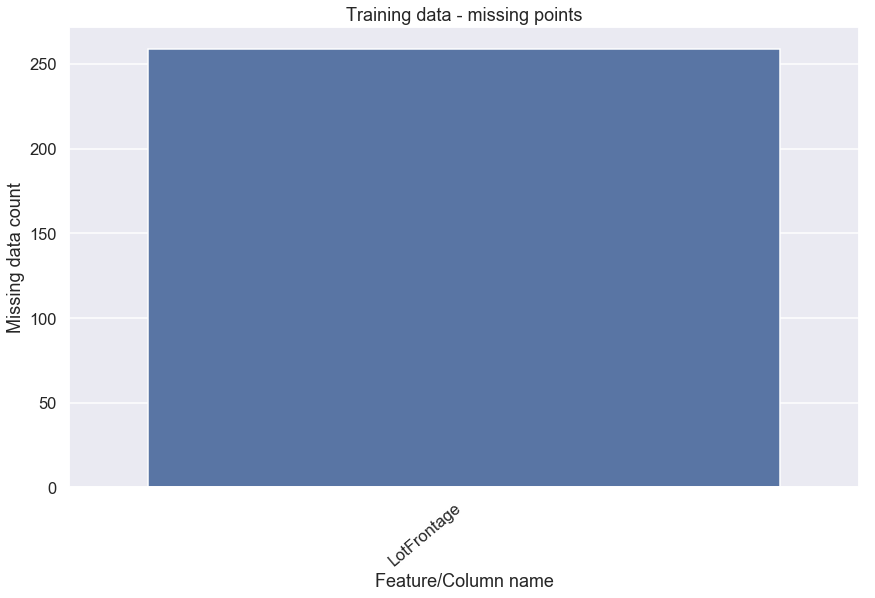

In [60]:
# Getting sum of NaNs over column axis.
homeprices_train_nan_count = homeprices_train.isnull().sum(axis = 0)

# Converting into dataframe
homeprices_train_nan_count = pd.DataFrame(homeprices_train_nan_count)

# Removing the ones which have associated zero count of NaNs
homeprices_train_nan_count2 = homeprices_train_nan_count.loc[(homeprices_train_nan_count != 0).all(axis=1), :]

# Sorting the values 
homeprices_train_nan_count2_sorted = homeprices_train_nan_count2.sort_values(homeprices_train_nan_count2.columns[0])

# Using sns barplot with x as index and y as the NaN count
ax = sns.barplot(x=homeprices_train_nan_count2_sorted.index, y=homeprices_train_nan_count2_sorted.columns[0], 
                 data=homeprices_train_nan_count2_sorted)

# Setting labels for x and y
ax.set(xlabel='Feature/Column name', ylabel='Missing data count')

# Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

# Setting up plot title
plt.title("Training data - missing points")

# Display all figures
plt.show()

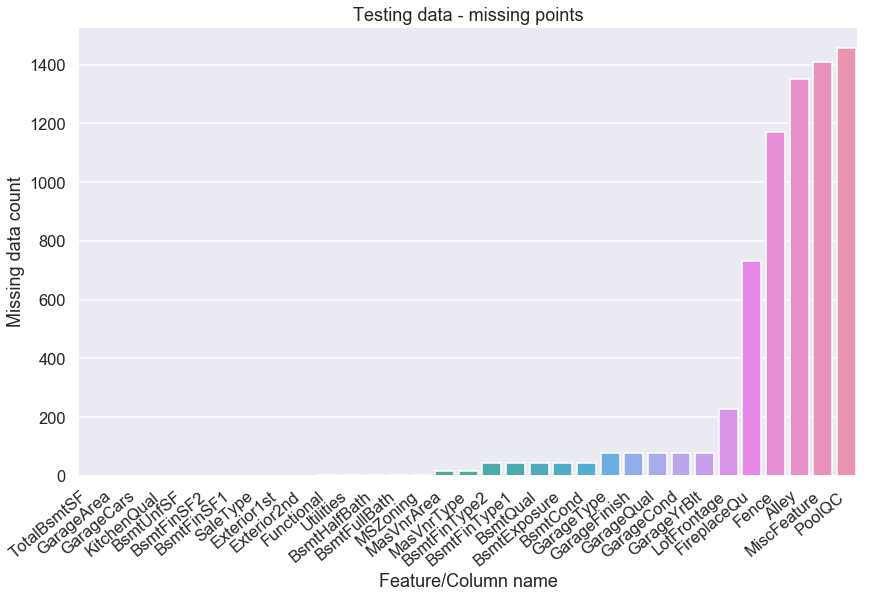

In [13]:
# Getting sum of NaNs over column axis.
homeprices_test_nan_count = homeprices_test.isnull().sum(axis = 0)

# Converting into dataframe
homeprices_test_nan_count = pd.DataFrame(homeprices_test_nan_count)

# Removing the ones which have associated zero count of NaNs
homeprices_test_nan_count2 = homeprices_test_nan_count.loc[(homeprices_test_nan_count != 0).all(axis=1), :]

# Sorting the values 
homeprices_test_nan_count2_sorted = homeprices_test_nan_count2.sort_values(homeprices_test_nan_count2.columns[0])

# Using sns barplot with x as index and y as the NaN count
ax = sns.barplot(x=homeprices_test_nan_count2_sorted.index, y=homeprices_test_nan_count2_sorted.columns[0], 
                 data=homeprices_test_nan_count2_sorted)

# Setting labels for x and y
ax.set(xlabel='Feature/Column name', ylabel='Missing data count')

# Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

# Setting up plot title
plt.title("Testing data - missing points")

# Display all figures
plt.show()

More about here - [Tight Layout](https://matplotlib.org/3.2.1/tutorials/intermediate/tight_layout_guide.html) 

### Imputing values - replacing NAs with appropriate values

Before we delve into imputation of missing values, I want to highlight a book for dealing with missing values. [Statistical Analysis with Missing Data, Second Edition](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119013563). It is very easy to replace missing values with a single mean or median but they mislead the statistical result, hence we are using KNN imputation which makes the most sense here given the nature of the dataset. 

We are NOT combining training and testing data, if we preprocess the data using any part of testing data, it ceases to be the testing dataset. They have to be processed separately.

#### Dealing with top five columns with missing values 
- PoolQC (Pool quality) 
- MiscFeature (Miscellaneous feature not covered in other categories)
- Alley (Type of alley access to property) 
- Fence (Fence quality)
- FireplaceQu (Fireplace quality)

#### Training data

In [14]:
# Simple code for filling NaN

homeprices_train["PoolQC"] = homeprices_train["PoolQC"].fillna("NoPool")
homeprices_train["MiscFeature"] = homeprices_train["MiscFeature"].fillna("NoFeatures")
homeprices_train["Alley"] = homeprices_train["Alley"].fillna("NoAlley")
homeprices_train["Fence"] = homeprices_train["Fence"].fillna("NoFence")
homeprices_train["FireplaceQu"] = homeprices_train["FireplaceQu"].fillna("NoFireplace")

#--------------------------------------------------------------------------------------------#

# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.

# homeprices_train.fillna({column:"None" for column in ['PoolQC','MiscFeature','Alley','Fence', 'NoFireplace']}, inplace=True)

#### Testing data

In [15]:
# Simple code for filling NaN

homeprices_test["PoolQC"] = homeprices_test["PoolQC"].fillna("NoPool")
homeprices_test["MiscFeature"] = homeprices_test["MiscFeature"].fillna("NoFeatures")
homeprices_test["Alley"] = homeprices_test["Alley"].fillna("NoAlley")
homeprices_test["Fence"] = homeprices_test["Fence"].fillna("NoFence")
homeprices_test["FireplaceQu"] = homeprices_test["FireplaceQu"].fillna("NoFireplace")

#--------------------------------------------------------------------------------------------#

# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.

# homeprices_train.fillna({column:"None" for column in ['PoolQC','MiscFeature','Alley','Fence', 'NoFireplace']}, inplace=True)

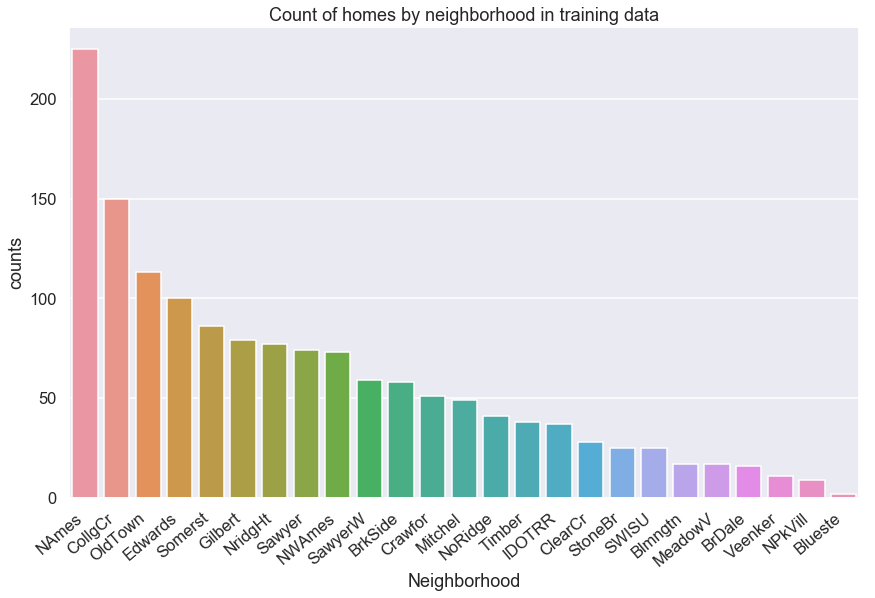

In [16]:
# Selecting Neighborhood then we are using group by with Neighborhood again then couting number of rows.
homeprices_train_neighbourhood_count = homeprices_train[["Neighborhood"]].groupby(["Neighborhood"]).\
                                    size().reset_index(name='counts').sort_values(['counts'], ascending=False)

# Creating ax object for SNS barplot
ax = sns.barplot(x=homeprices_train_neighbourhood_count.Neighborhood, y=homeprices_train_neighbourhood_count.counts, \
                 data = homeprices_train_neighbourhood_count)

# Rotating the labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight layout
plt.tight_layout()

# Setting plot title
plt.title("Count of homes by neighborhood in training data")

# Display all figures
plt.show()

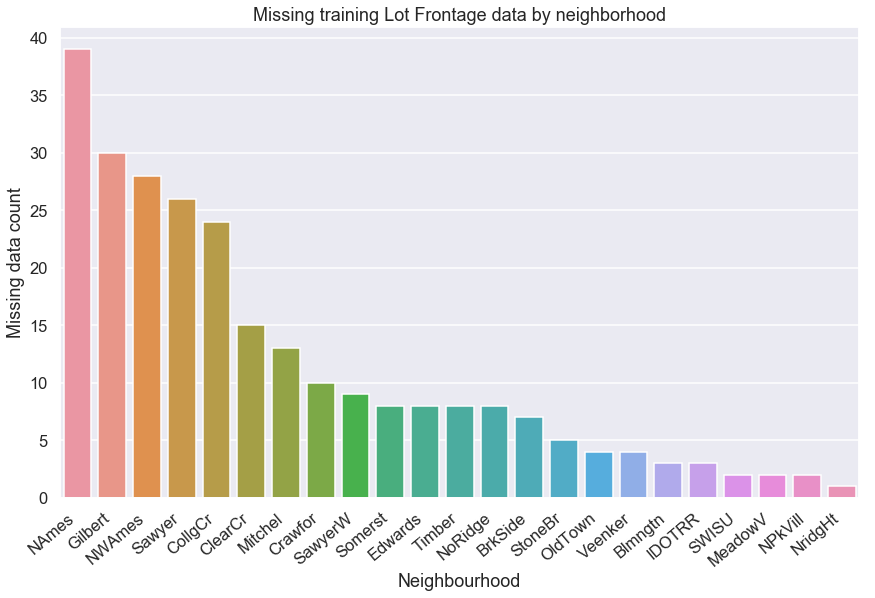

In [17]:
# Getting sum of NaNs over column axis.
homeprices_train_neighborhood_nan_count = homeprices_train.groupby("Neighborhood").agg({'LotFrontage': 
                                                                                        lambda x: x.isnull().sum()})

# Converting into dataframe
homeprices_train_nan_count = pd.DataFrame(homeprices_train_neighborhood_nan_count)

# Removing the ones which have associated zero count of NaNs
homeprices_train_nan_count2 = homeprices_train_nan_count.loc[(homeprices_train_nan_count != 0).all(axis=1), :]

# Sorting the values 
homeprices_train_nan_count2_sorted = homeprices_train_nan_count2.sort_values(homeprices_train_nan_count2.columns[0], 
                                                                             ascending=False)

# Using sns barplot with x as index and y as the NaN count
ax = sns.barplot(x=homeprices_train_nan_count2_sorted.index, y=homeprices_train_nan_count2_sorted.columns[0], 
                 data=homeprices_train_nan_count2_sorted)

# Setting labels for x and y
ax.set(xlabel='Neighbourhood', ylabel='Missing data count')

# Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

plt.title("Missing training Lot Frontage data by neighborhood")

plt.show()

### Before we impute the values of Lot Frontage let's get everything else sorted

In [18]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:"NoGarage" for column in 
                         ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']}, 
                        inplace=True)

homeprices_test.fillna({column:"NoGarage" for column in 
                         ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']}, 
                        inplace=True)

In [19]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:0 for column in 
                         ['GarageYrBlt', 'GarageArea', 'GarageCars']}, 
                        inplace=True)

homeprices_test.fillna({column:0 for column in 
                         ['GarageYrBlt', 'GarageArea', 'GarageCars']}, 
                        inplace=True)

In [20]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:0 for column in 
                         ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']}, 
                        inplace=True)

homeprices_test.fillna({column:0 for column in 
                         ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']}, 
                        inplace=True)

In [21]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:"NoBsmt" for column in 
                         ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']}, 
                        inplace=True)

homeprices_test.fillna({column:"NoBsmt" for column in 
                         ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']}, 
                        inplace=True)

In [22]:
homeprices_train["MasVnrType"].fillna("None", inplace=True)
homeprices_train["MasVnrArea"].fillna(0, inplace=True)

homeprices_test["MasVnrType"].fillna("None", inplace=True)
homeprices_test["MasVnrArea"].fillna(0, inplace=True)

In [23]:
homeprices_train['MSZoning'].fillna(homeprices_train['MSZoning'].mode()[0], inplace=True)
homeprices_test['MSZoning'].fillna(homeprices_test['MSZoning'].mode()[0], inplace=True)

In [24]:
homeprices_train['Exterior1st'].fillna(homeprices_train['Exterior1st'].mode()[0], inplace=True)
homeprices_test['Exterior1st'].fillna(homeprices_test['Exterior1st'].mode()[0], inplace=True)
homeprices_train['Exterior2nd'].fillna(homeprices_train['Exterior2nd'].mode()[0], inplace=True)
homeprices_test['Exterior2nd'].fillna(homeprices_test['Exterior2nd'].mode()[0], inplace=True)

In [25]:
homeprices_train['SaleType'].fillna(homeprices_train['SaleType'].mode()[0], inplace=True)
homeprices_test['SaleType'].fillna(homeprices_test['SaleType'].mode()[0], inplace=True)

In [26]:
homeprices_train = homeprices_train[homeprices_train['MSSubClass'].notna()]
homeprices_test = homeprices_test[homeprices_test['MSSubClass'].notna()]
# homeprices_train.dropna(subset=['MSSubClass'], inplace=True)
# homeprices_test.dropna(subset=['MSSubClass'], inplace=True)

In [27]:
homeprices_train['Utilities'].fillna(homeprices_train['Utilities'].mode()[0], inplace=True)
homeprices_test['Utilities'].fillna(homeprices_test['Utilities'].mode()[0], inplace=True)

In [28]:
homeprices_train["Functional"].fillna("Typ", inplace=True)
homeprices_test["Functional"].fillna("Typ", inplace=True)

In [29]:
homeprices_train['Electrical'].fillna(homeprices_train['Electrical'].mode()[0], inplace=True)
homeprices_test['Electrical'].fillna(homeprices_test['Electrical'].mode()[0], inplace=True)

In [30]:
homeprices_train['KitchenQual'].fillna(homeprices_train['KitchenQual'].mode()[0], inplace=True)
homeprices_test['KitchenQual'].fillna(homeprices_test['KitchenQual'].mode()[0], inplace=True)

In [31]:
homeprices_test.shape

(1459, 80)

### Plotting strongest correlation to Sale Price

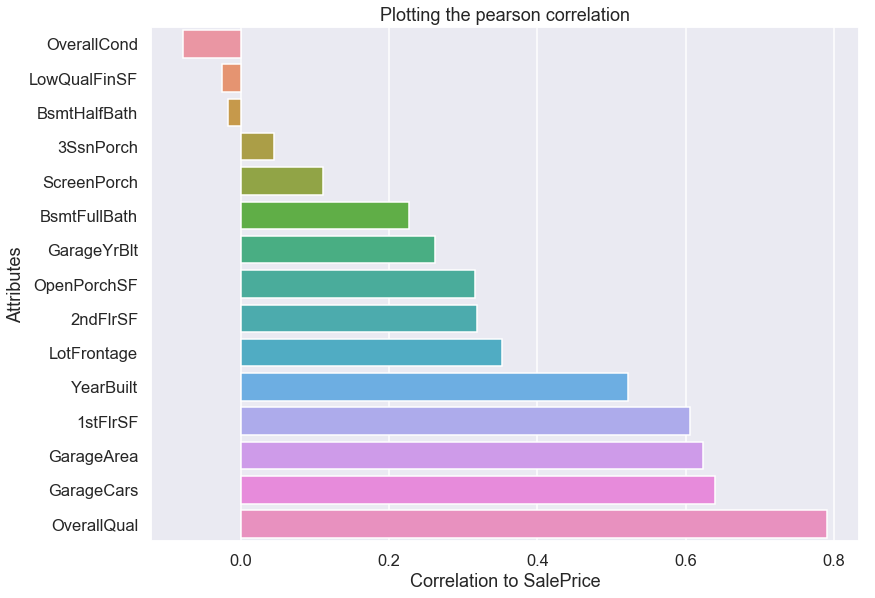

In [32]:
# Pearson correlation of whole matrix
corr_list = homeprices_train.corr().unstack().sort_values().drop_duplicates()

# Converting to dataframe
corr_list = pd.DataFrame(corr_list)

# Resetting multiindex to normal to columns so we can work easily
corr_list = corr_list.reset_index()

corr_to_dependent = corr_list[corr_list['level_1']=='SalePrice'].sort_values(corr_list.columns[2], ascending=True)

# Creating a bar plot
ax = sns.barplot(x=corr_to_dependent.columns[2],y=corr_to_dependent.level_0, data=corr_to_dependent, ci=0)

# Setting labels for x and y
ax.set(xlabel='Correlation to SalePrice', ylabel='Attributes')

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

# Setting up plot title
plt.title("Plotting the pearson correlation")

# Display all figures
plt.show()

## Creating dummy variables so we can now impute our Lot Front values with KNN 

Combining just to make sure make sure we get the same dummy varibles, it is one hot encoding and will not affect the statistical results.

In [33]:
all_data = homeprices_train.append(homeprices_test)

In [34]:
all_data_dummy = pd.get_dummies(all_data)

In [73]:
homeprices_train_dummy = all_data_dummy[all_data_dummy.SalePrice != 0]

homeprices_test_dummy = all_data_dummy[all_data_dummy.SalePrice == 0]

In [36]:
homeprices_test_dummy_features = homeprices_test_dummy.loc[:, homeprices_test_dummy.columns != 'SalePrice']

homeprices_train_dummy_features = homeprices_train_dummy.loc[:, homeprices_train_dummy.columns != 'SalePrice']

homeprices_train_dummy_dependent = homeprices_train_dummy.loc[:, 'SalePrice']

In [37]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights='uniform')

homeprices_train_dummy_imputed = imputer.fit_transform(homeprices_train_dummy)

In [38]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights='uniform')

homeprices_test_dummy_imputed = imputer.fit_transform(homeprices_test_dummy_features)

In [66]:
# print(homeprices_train_dummy_features.isnull().sum() != 0)
# print(homeprices_test_dummy_features.isnull().sum() != 0)

## Removing outliers

In [67]:
# sns.boxplot(x=homeprices_train['SalePrice'])
# plt.title("Box plot for spotting the outliers")
# plt.show()

In [68]:
# # Tuple unpacking returns the fig and axes objects as written below
# # ax1 and ax2 refer to each cell in subplots argument
# # i.e. plt.subplot(row,column), for example: row x column = number of objects returned
# fig, (ax1,ax2) = plt.subplots(1, 2)

# # Distribution plot for SalePrice
# sns.distplot(homeprices_train['SalePrice'], ax=ax1)

# # Distribution plot for log of SalePrice
# sns.distplot(np.log(homeprices_train['SalePrice']), ax=ax2)

# #
# plt.title("Distribution of the Sale Price")

# #
# plt.show()

In [69]:
# for colname in ["MSZoning", "LotShape", "Functional"]:
#     # Using plt figure to intiate a new figure everytime we plot.
#     # Else this would just create a combined figure which wouldn't make sense.
#     plt.figure()
    
#     # Using Seahorse scatterplot visualize a relationship between  
#     ax = sns.scatterplot(x="GrLivArea", y="SalePrice", hue=colname, data=homeprices_train)
    
#     # Setting label for x and y axes.
#     ax.set(xlabel='Above ground living area sq. ft.', ylabel='Sale Price')

## Starting the modelling part

In [39]:
from sklearn import linear_model
import statsmodels.api as sm

In [40]:
assert homeprices_train_dummy_features.shape[1] == homeprices_test_dummy_features.shape[1], "They don't have same number of columns."

## Grid search GBM

In [72]:
# split_ratio = 0.7 # 70%/30% train/test split

# # execute split
# split = np.random.rand(len(homeprices_train_dummy)) < split_ratio
# train = homeprices_train_dummy[split]
# valid = homeprices_train_dummy[~split]

# # summarize split
# print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
# print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

In [42]:
# # Getting feature labels for h20 use
# X_labels = [col for col in (homeprices_train_dummy_imputed.loc[:, homeprices_train_dummy_imputed.columns != 'SalePrice']).columns]

# # Setting y label
# y_label = 'SalePrice'

Split the training and valid into X and Y matrix so we can work.

In [58]:
from sklearn.model_selection import train_test_split

if isinstance(homeprices_train_dummy_imputed, pd.DataFrame):
    print("Yay! it's a dataframe object.")
else:
    print("No it is not, it if type: ", type(homeprices_train_dummy_imputed))

# X_features = homeprices_train_dummy_imputed.loc[:, homeprices_train_dummy_imputed.columns != 'SalePrice']
# y_saleprice = homeprices_train_dummy_imputed.loc[:, 'SalePrice']

X_features = homeprices_train_dummy_imputed[:, :-2]
y_saleprice = homeprices_train_dummy_imputed[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_saleprice, test_size = 0.3, random_state = 0)

train, valid = train_test_split(homeprices_train_dummy_imputed, test_size = 0.3, random_state = 0)

print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Validation data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))



No it is not, it if type:  <class 'numpy.ndarray'>
Train data rows = 1022, columns = 301
Validation data rows = 438, columns = 301


In [59]:
print(y_saleprice)

[0. 0. 0. ... 0. 0. 0.]


In [71]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

LinAlgError: SVD did not converge in Linear Least Squares

In [50]:
y_pred = regr.predict(homeprices_test_dummy_features)

In [51]:
print(y_pred)

[112335.55882023 159378.87544629 186481.53573535 ... 176622.15814891
 115212.87697574 223322.78766938]


In [52]:
# GBM grid search
best_glm = model.gbm_grid(X_labels, y_label, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)


print(best_glm.coef)


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_Key_Frame__upload_b6b2077958aa0cdef57d537a3a844ede.hex_model_python_1591499811234_1_model_18


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,97.0,97.0,13834.0,3.0,3.0,3.0,4.0,8.0,6.680412




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 249396738.09435093
RMSE: 15792.299962144556
MAE: 11084.340967465754
RMSLE: 0.09654774421009779
Mean Residual Deviance: 249396738.09435093

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 992952141.6968309
RMSE: 31511.143135355007
MAE: 16334.571733570921
RMSLE: 0.1316638288444757
Mean Residual Deviance: 992952141.6968309

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-06-06 23:17:19,20.251 sec,0.0,76730.941481,56848.365260,5.887637e+09,85354.709090,59149.613141,7.285426e+09
1,,2020-06-06 23:17:19,20.277 sec,1.0,71024.999728,52549.530333,5.044551e+09,80047.991706,54980.862955,6.407681e+09
2,,2020-06-06 23:17:19,20.284 sec,2.0,66034.519390,48653.706122,4.360558e+09,75357.182359,51363.460404,5.678705e+09
3,,2020-06-06 23:17:19,20.294 sec,3.0,61480.259616,45242.964714,3.779822e+09,71128.307023,48240.183835,5.059236e+09
4,,2020-06-06 23:17:19,20.303 sec,4.0,57297.982915,42007.139647,3.283059e+09,67459.783602,45154.393149,4.550822e+09
5,,2020-06-06 23:17:19,20.312 sec,5.0,53691.573003,39188.070939,2.882785e+09,63998.815203,42381.717540,4.095848e+09
6,,2020-06-06 23:17:19,20.319 sec,6.0,50445.100189,36728.293557,2.544708e+09,60942.083844,39952.073517,3.713938e+09
7,,2020-06-06 23:17:19,20.328 sec,7.0,47624.685100,34469.651006,2.268111e+09,58268.590293,37671.253646,3.395229e+09
8,,2020-06-06 23:17:20,20.335 sec,8.0,45047.967660,32402.842787,2.029319e+09,55699.144025,35636.809690,3.102395e+09
9,,2020-06-06 23:17:20,20.346 sec,9.0,42639.062665,30439.385182,1.818090e+09,53229.906145,33678.206329,2.833423e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,OverallQual,1.529077e+13,1.000000,0.520592
1,GrLivArea,4.508502e+12,0.294851,0.153497
2,GarageCars,1.864411e+12,0.121930,0.063476
3,BsmtFinSF1,1.287684e+12,0.084213,0.043841
4,TotalBsmtSF,1.284160e+12,0.083983,0.043721
5,1stFlrSF,1.031655e+12,0.067469,0.035124
6,YearBuilt,5.291017e+11,0.034603,0.018014
7,YearRemodAdd,4.352192e+11,0.028463,0.014818
8,LotArea,3.788956e+11,0.024779,0.012900
9,BsmtQual_Ex,3.499721e+11,0.022888,0.011915



See the whole table with table.as_data_frame()
<bound method ModelBase.coef of >
